# Latent Dirichlet allocation (LDA)

In [1]:
import numpy as np
import pandas as pd
import gensim
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [2]:
#import data
comments = pd.read_csv('comments.csv')[['comments']].dropna().drop_duplicates()
len(comments['comments'])

4236

In [3]:
#Preprocessing

STOP_WORDS = STOP_WORDS.union({'ll', 've', 'pron',
                               'good','great', 'nice',
                               'ride','route','road','rt','roads'
                              })

## Text Processing

In [29]:
ngram_range = (2, 4)

vectorizer = CountVectorizer(ngram_range=ngram_range,
                             stop_words=STOP_WORDS,
                            )
analyzer = vectorizer.build_analyzer()

texts = comments.comments.values.tolist()
processed_text = [analyzer(text) for text in texts]

In [30]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))

Number of unique tokens: 488823


In [31]:
corpus = [dictionary.doc2bow(t) for t in processed_text]

## Initial LDA Model

In [43]:
#LDA model parameters
num_topics = 4
num_words = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=17, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

pprint(lda_model.print_topics(num_words=num_words))

[(0,
  '0.005*"beautiful scenery" + 0.004*"little traffic" + 0.003*"speed limit" + '
  '0.003*"elevation changes" + 0.003*"tail dragon" + 0.003*"twists turns" + '
  '0.003*"highly recommend" + 0.003*"blue ridge" + 0.002*"places stop" + '
  '0.002*"ridden times"'),
 (1,
  '0.002*"tunnel trees" + 0.002*"turn left" + 0.001*"turn right" + '
  '0.001*"crotch rocket" + 0.001*"speed limit" + 0.001*"legs inn" + '
  '0.001*"cross village" + 0.001*"twisties fun" + 0.001*"stop sign" + '
  '0.001*"places stop"'),
 (2,
  '0.001*"https www" + 0.001*"www youtube com" + 0.001*"youtube com" + '
  '0.001*"www youtube" + 0.001*"dragon tail" + 0.001*"starting turn" + '
  '0.001*"rode 30" + 0.001*"salt river" + 0.001*"oh ohio" + 0.001*"ohio '
  'dragon"'),
 (3,
  '0.002*"cody wy" + 0.001*"chief joseph scenic" + 0.001*"joseph scenic" + '
  '0.001*"time loop" + 0.001*"starved rock" + 0.001*"cool views" + 0.001*"ar '
  '21" + 0.001*"red bluff" + 0.001*"starved rock state park" + 0.001*"pass '
  'times"')]


In [44]:
# get_document_topics method shows the topics found 
# in each corpus doc
lda_model.get_document_topics(corpus[1])

[(0, 0.7300124), (1, 0.026473997), (2, 0.22789559), (3, 0.015618061)]

In [45]:
# extracts dominant topic (and percentage) for each comment

def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [46]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

In [47]:
# len(main_topic_df)

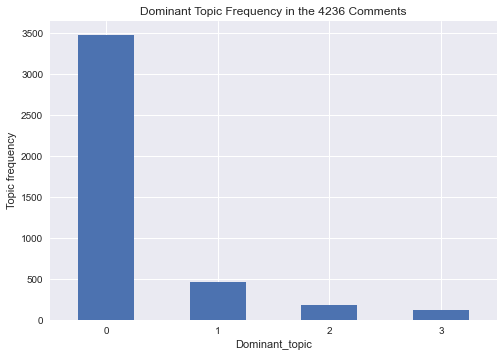

In [48]:
plt.style.use('seaborn')

grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the {len(comments)} Comments',
        ylabel='Topic frequency');


## Representative data

What's the "most representative" comment we have in the data for each topic?  

In [49]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(3)])
# representatives
for i in range(len(representatives)):
    print(f'''
        Document: {representatives.index[i]}  
        Dominant topic: {representatives.loc[representatives.index[i]]['Dominant_topic']}\n 
    ''')
    print(texts[representatives.index[i]] + '\n ------- \n')


        Document: 695  
        Dominant topic: 0
 
    
Nice ride, several winding roads, beautiful in the spring... fields full of bluebonnets,Rocket cafe is always great stop opens at Noon on Sundays,Live in the area and always enjoy the roads around Waxahachie.  Never pieced it all together like this route does.  Very nice roads, curves, rolling hills, shade, sun; all facets of a nice ride.  The road between Rockett and Palmer has always been one of my favorites.  Bardswell reservoir was much larger than I expected being the first time along FM34.  Overall an enjoyable spring ride on a Saturday afternoon.,This route is in my back yard and I ride it or parts of it on a very regular basis on all types of bikes from BMW touring bikes, sports bikes and cruisers, The roads are all in good condition  with nice curves twist and turns.  The views are beautiful especially in late March through May.  Don't miss the great sushi and American food at the Bristol General Store on FM 660 or The 

## Length of documents in each topic

In [50]:
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.hist(d_lens, bins=50)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.gca().set(xlabel='Document word count', ylabel='Number of documents', xlim=(0, 450), 
            title='Distribution of Comment Lengths for {} Comments in Topic {}'.format(len(d_lens), topic));

In [51]:
slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=3), Output()), _dom_classes=('widget-interac…

## Top word distribution per topic

Indices of top words: 
{84736, 11521, 7425, 28691, 15647, 20023, 45368, 48955, 84803, 131656, 15694, 130669, 130671, 130674, 4980, 141177, 4473, 34940, 15490, 134, 64651, 105360, 130705, 665, 668, 1956, 103845, 2982, 5813, 132277, 16074, 16075, 972, 16080, 113875, 19925, 2529, 11760}



[Text(0, 0.5, 'Word frequency'),
 Text(0.5, 1.0, 'Word Frequencies by Topic, Combining the Top 38 Words in Each Topic')]

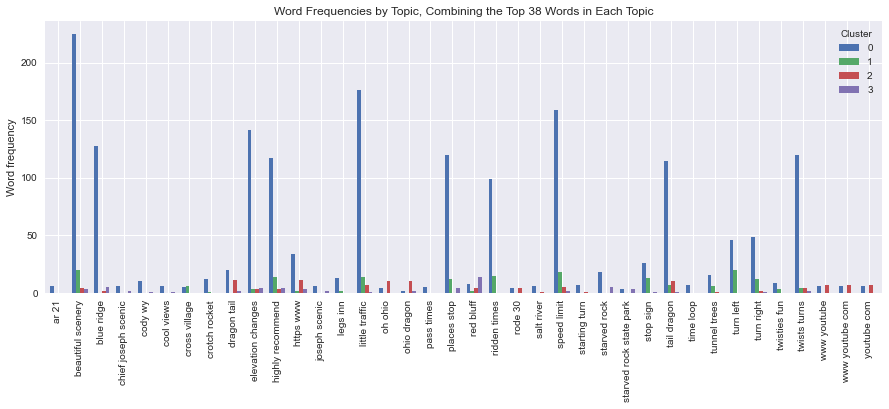

In [52]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])

print('Indices of top words: \n{}\n'.format(lda_top_words_index))
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']
(
    lda_top_words_df
    .groupby('Cluster').sum().transpose()
    .plot.bar(figsize=(15, 5), width=0.7)
    .set(ylabel='Word frequency', 
         title=f'Word Frequencies by Topic, Combining the Top {len(lda_top_words_index)} Words in Each Topic')
)

## Coherence scores based on number of topics

Coherence scores for the ngram range: (2, 4) 
 [(1, 0.21300752083840652), (2, 0.3776526410567235), (3, 0.413150091170489), (4, 0.48856209625923575), (5, 0.4749763971508833), (6, 0.5121274932882053), (7, 0.5566498473770802), (8, 0.5600037584409502), (9, 0.5483508199176442), (10, 0.5912511167683759)]


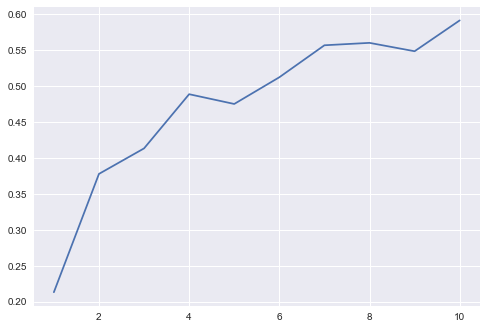

In [42]:
coherence_scores = []

for n in range(1, 11):
    mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                          id2word=dictionary,
                                          num_topics=n, 
                                          random_state=117, update_every=1,
                                          chunksize=1500, 
                                          passes=5, iterations=10,
                                          alpha='asymmetric', eta=1/100,
                                          per_word_topics=True)
    cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
                                                 texts=processed_text,
                                                 dictionary=dictionary)
    coherence_scores.append((n, cmodel.get_coherence()))

topic_range = [coherence_scores[i][0] for i in range(len(coherence_scores))]
cscore = [coherence_scores[i][1] for i in range(len(coherence_scores))]

In [ ]:
print(f'Coherence scores for the ngram range: {ngram_range} \n {coherence_scores}')
plt.plot(topic_range,cscore)

# Conclusions

- There seem to be 3-4 groups of users making comments on this website.
- IF 3:
    0. The 'core' group of users make most of the comments.
    1. The second group are those who are not as frequent commenters, but when they do post, they usually share videos/links to other sites.
    2. The last group do not frequently comment or share videos/links.
- IF 4:
    0. The 'core' group of users make most of the comments.
    1. Post like core group, but less overall. Maybe newer members/budding 'core' group?
    2. People riding the tail of the dragon.
    3. Other infrequent posters.